In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import csv
import argparse
import os

from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

Скопируем прилагаемые вместе с лабораторной функции для генерации и визуализации временных рядов

In [2]:
def generate_time_series(n_points=1000, has_trend=True, has_seasonality=True, seed=None):
    """
    Генерирует временной ряд со случайными параметрами без использования
    Pandas
    Параметры:
    ----------
    n_points : int
    Количество точек данных
    has_trend : bool
    Добавлять ли тренд
    has_seasonality : bool
    Добавлять ли сезонность
    seed : int или None
    Seed для воспроизводимости
    Возвращает:
    -----------
    tuple: (dates, values) где dates - список строк дат, values - список
    значений
    """
    
    if seed is not None:
        np.random.seed(seed)
    
    # Генерируем временные метки (ежедневные данные начиная с 2020-01-01)
    start_date = datetime(2020, 1, 1)
    dates = [(start_date + timedelta(days=i)).strftime('%Y-%m-%d') for i in range(n_points)]
    
    # Базовый шум (случайная компонента)
    noise = np.random.normal(0, 5, n_points)
    
    # Инициализируем компоненты
    trend_component = np.zeros(n_points)
    seasonal_component = np.zeros(n_points)
    
    # Генерируем тренд, если требуется
    if has_trend:
        # Случайно выбираем тип тренда: линейный, квадратичный или логарифмический
        trend_type = np.random.choice(['linear', 'quadratic', 'logarithmic'])
    
    if trend_type == 'linear':
        # Линейный тренд: y = mx + b
        slope = np.random.uniform(-0.5, 0.5) # случайный наклон
        intercept = np.random.uniform(50, 100) # случайное начальное значение
        trend_component = slope * np.arange(n_points) + intercept
    elif trend_type == 'quadratic':
        # Квадратичный тренд: y = ax^2 + bx + c
        a = np.random.uniform(-0.001, 0.001)
        b = np.random.uniform(-0.1, 0.1)
        c = np.random.uniform(50, 100)
        x = np.arange(n_points)
        trend_component = a * x**2 + b * x + c
    else: # logarithmic
        # Логарифмический тренд: y = a*log(x+1) + b
        a = np.random.uniform(10, 30)
        b = np.random.uniform(50, 100)
        trend_component = a * np.log(np.arange(n_points) + 1) + b
    
    # Генерируем сезонность, если требуется
    if has_seasonality:
        # Случайное количество сезонных компонент (1-3)
        n_seasons = np.random.randint(1, 4)
        for _ in range(n_seasons):
            # Случайные параметры для каждой сезонной компоненты
            amplitude = np.random.uniform(10, 30) # амплитуда
            period = np.random.uniform(30, 365) # период в днях
            phase = np.random.uniform(0, 2*np.pi) # фаза
            # Создаем сезонную компоненту (синусоида)
            seasonal_component += amplitude * np.sin(2*np.pi*np.arange(n_points)/period + phase)
    # Комбинируем все компоненты
    values = noise + trend_component + seasonal_component
    return dates, values

In [4]:
def plot_time_series(dates, values, figsize=(14, 6)):
    """
    Визуализирует временной ряд без использования Pandas
    Параметры:
    ----------
    dates : list
    Список дат в строковом формате
    values : list или np.array
    Список значений временного ряда
    figsize : tuple
    Размер фигуры
    """
    # Преобразуем строки дат в объекты datetime для matplotlib
    date_objects = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in dates]
    
    plt.figure(figsize=figsize)
    
    # Строим график временного ряда
    plt.plot(date_objects, values, label='Временной ряд', color='blue', linewidth=1.5)
    plt.title('Сгенерированный временной ряд', fontsize=16, fontweight='bold')
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Значение', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Автоматически форматируем ось X для дат
    plt.gcf().autofmt_xdate()
    
    # Добавляем информацию о данных
    values_array = np.array(values)
    stats_text = f"Всего точек: {len(values)}\nСреднее:{np.mean(values_array):.2f}\nСтандартное отклонение:{np.std(values_array):.2f}"
    plt.figtext(0.02, 0.02, stats_text, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))
    plt.tight_layout()
    plt.show()

Сгенерируем временной ряд с помощью функции с параметрами по умолчанию:

In [5]:
dates, values = generate_time_series()
df = pd.DataFrame({
    'date': pd.to_datetime(dates),
    'value': values
})
df = df.set_index('date')
df.to_csv('time_series.csv')

Построим его график:

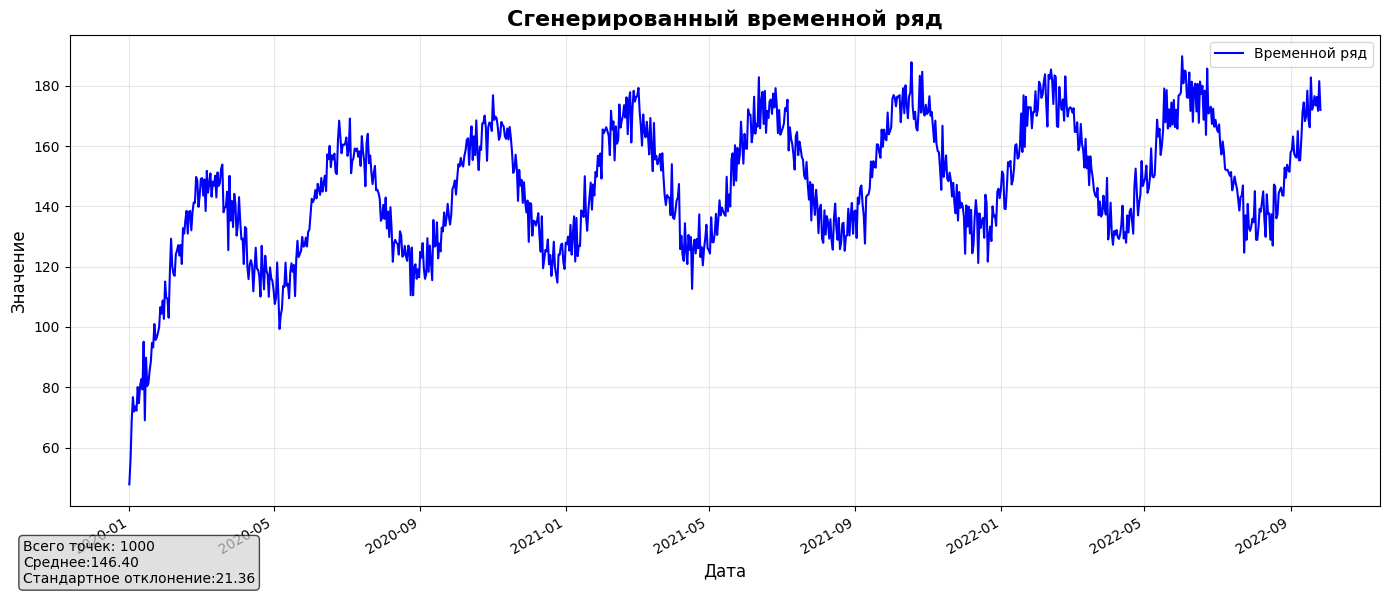

In [6]:
plot_time_series(dates, values)

Проведем статистические тесты

In [7]:
result_adf = adfuller(df['value'])
print(f'ADF Statistic: {result_adf[0]}, p-value: {result_adf[1]}')
print("Critical Values:")
for key, value in result_adf[4].items():
    print(f" {key}: {value}")

ADF Statistic: -6.57148866367194, p-value: 7.91559882032823e-09
Critical Values:
 1%: -3.4370334797663844
 5%: -2.8644907213150725
 10%: -2.568341114581742


In [8]:
result_kpss = kpss(df['value'])
print(f'KPSS Statistic: {result_kpss[0]}, p-value: {result_kpss[1]}')
print("Critical Values:")
for key, value in result_kpss[3].items():
    print(f" {key}: {value}")

KPSS Statistic: 1.4128499259804934, p-value: 0.01
Critical Values:
 10%: 0.347
 5%: 0.463
 2.5%: 0.574
 1%: 0.739


/tmp/ipykernel_47/1695851709.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_kpss = kpss(df['value'])


Разделим ряд на компоненты

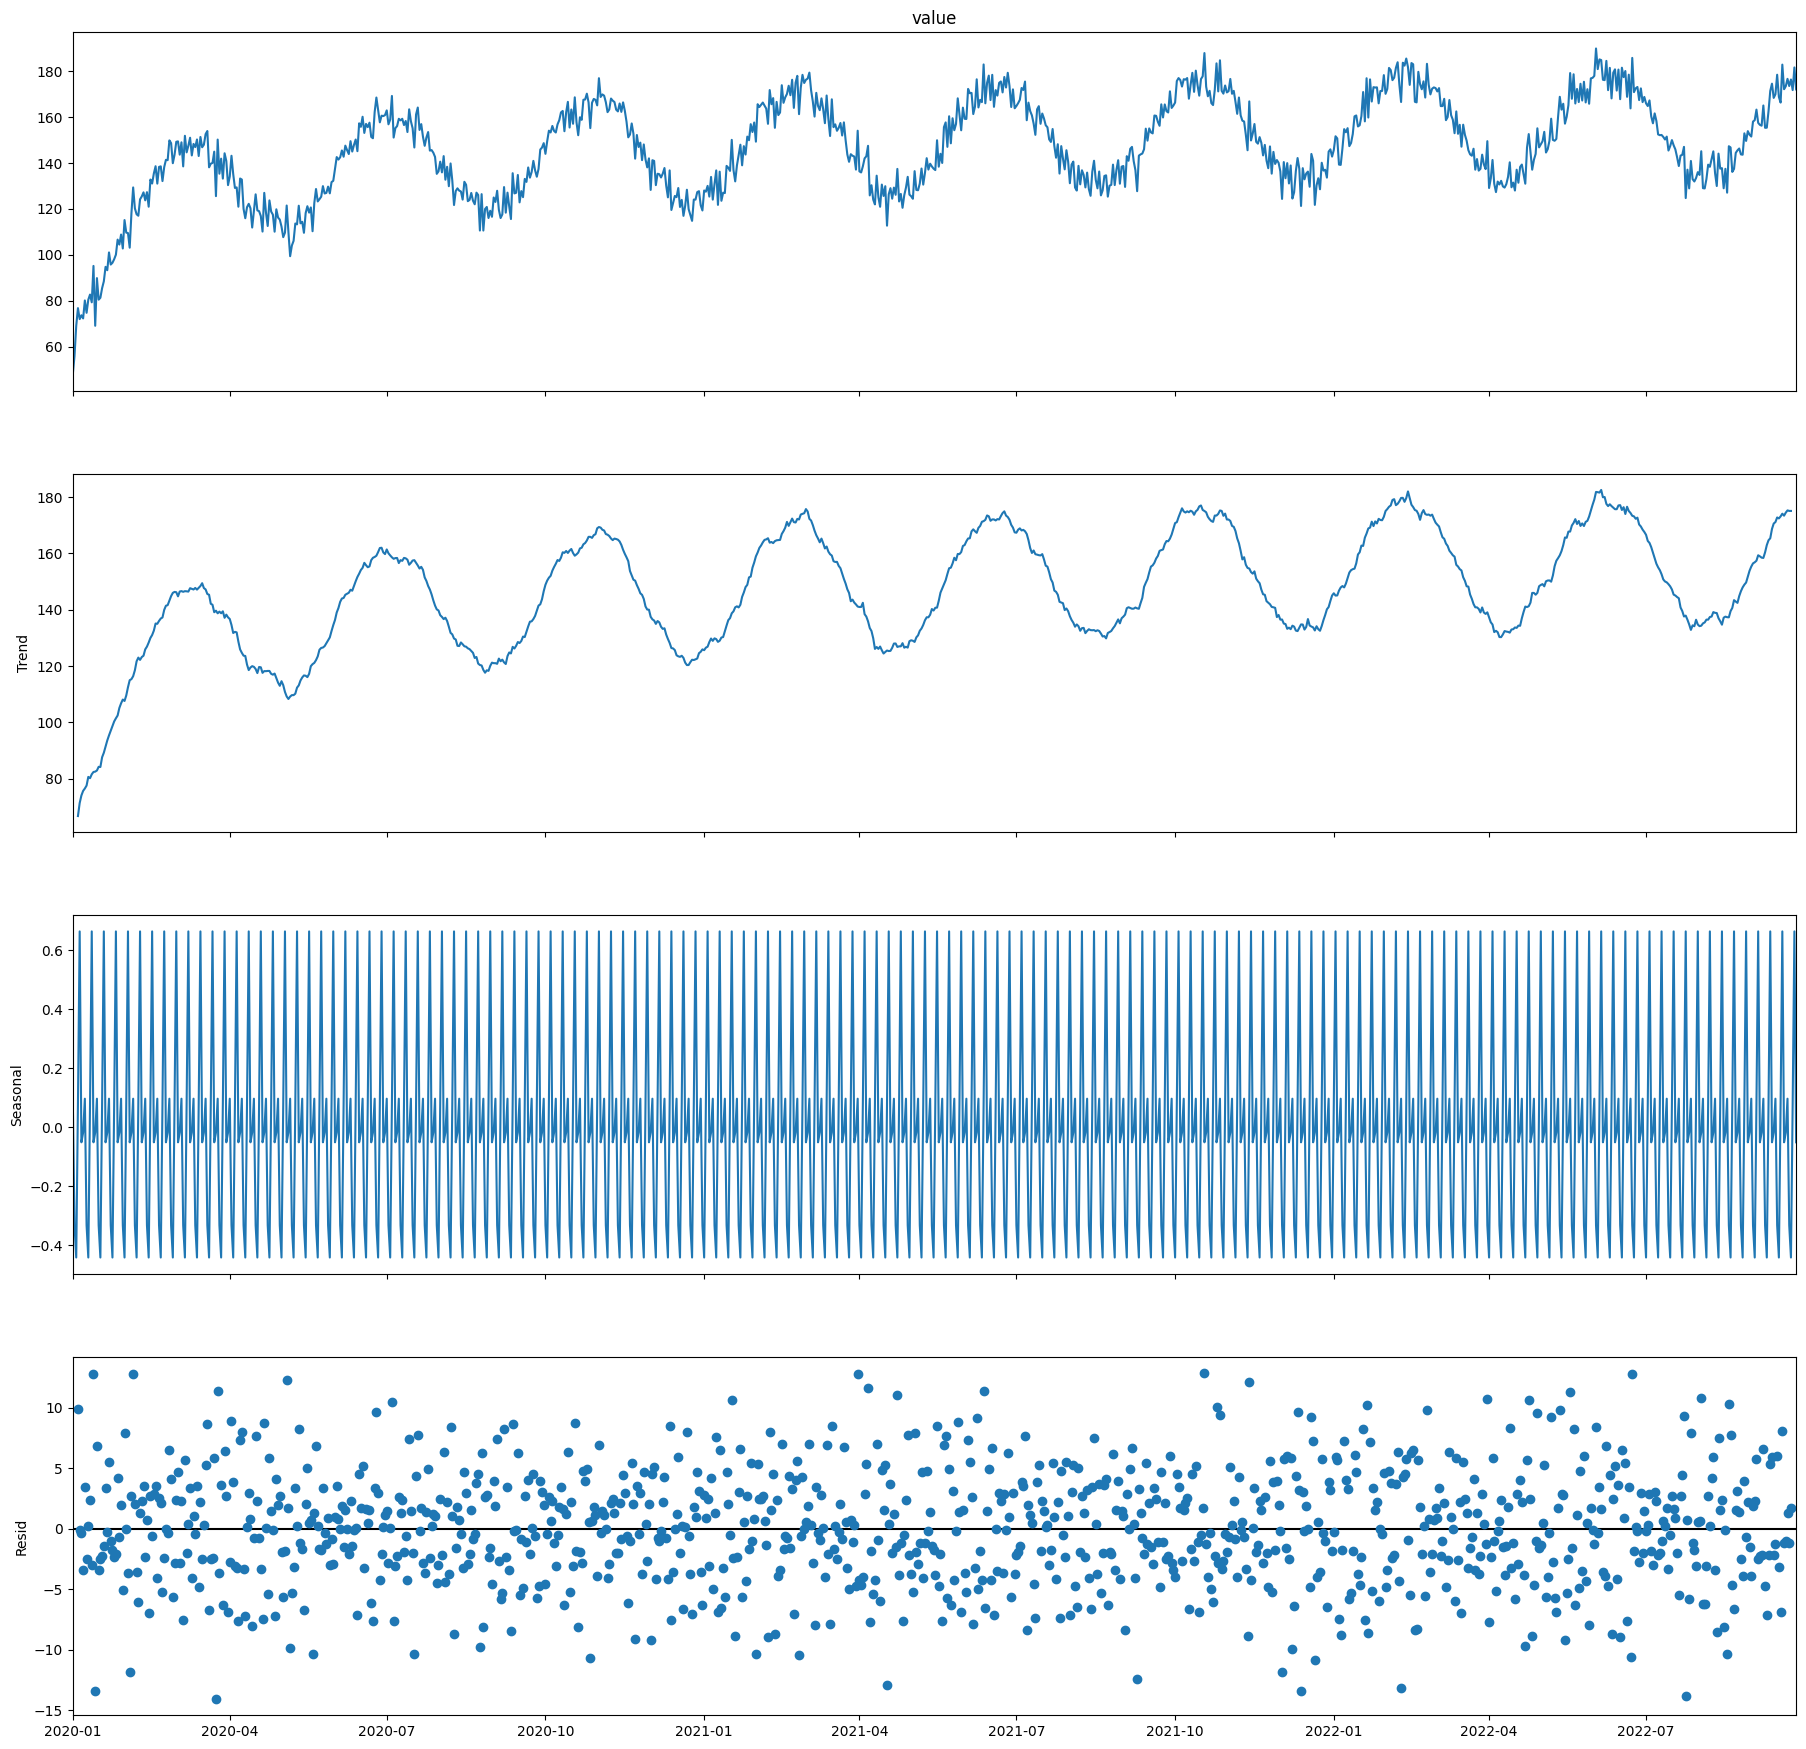

In [9]:
decomposiotion = seasonal_decompose(df['value'], model='additive')
decomposiotion.plot().set_size_inches(20, 20)
plt.show()

Отрисуем автокорреляционные функции для нашего временного ряда

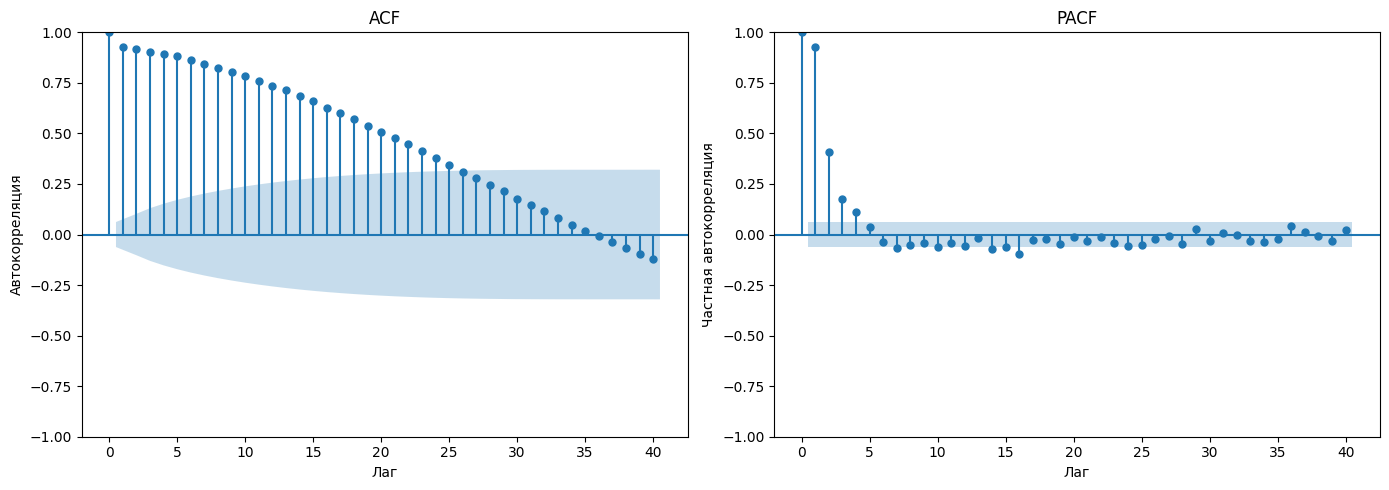

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF исходного ряда
plot_acf(df['value'].dropna(), lags=40, ax=axes[0], title='ACF')
axes[0].set_xlabel('Лаг')
axes[0].set_ylabel('Автокорреляция')

plot_pacf(df['value'].dropna(), lags=40, ax=axes[1], title='PACF')
axes[1].set_xlabel('Лаг')
axes[1].set_ylabel('Частная автокорреляция')
result = seasonal_decompose(df['value'], model='additive', period=12)
residuals = result.resid.dropna()

plt.tight_layout()
plt.show()

Разделим данные на обучающие и тестовые

In [13]:
train_size = int(len(df) * 0.9)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

Так как наш временной ряд имеет явную сезонность и тренд, а также объем данных не слишком маленький и не слишком большой, то нам подходит статистический метод на основе ARIMA - SARIMAX. Он также дает хорошие интерпретируемые результаты и позволяет получать 95% ошибку, что дальше понадобиться при построении графиков.

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

arima_model = SARIMAX(train_df['value'], order = (2,1,1), seasonal_order = (4,0,3,12))
arima_result = arima_model.fit()
arima_result.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                      value   No. Observations:                  900
Model:             SARIMAX(2, 1, 1)x(4, 0, [1, 2, 3], 12)   Log Likelihood               -2843.772
Date:                                    Fri, 12 Dec 2025   AIC                           5709.543
Time:                                            14:54:13   BIC                           5762.357
Sample:                                        01-01-2020   HQIC                          5729.720
                                             - 06-18-2022                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0840      0.049     -1.703      0.089      -0.181       0.013
ar.L2         -0.0256      0.045     -0.569      0.569      -0.114       0.063
ma.L1         -0.7658      0.034    -22.642      0.000      -0.832      -0.699
ar.S.L12       0.6381      0.175      3.641      0.000       0.295       0.982
ar.S.L24       0.5753      0.268      2.145      0.032       0.050       1.101
ar.S.L36      -0.9959      0.162     -6.146      0.000      -1.314      -0.678
ar.S.L48       0.0170      0.039      0.434      0.664      -0.060       0.094
ma.S.L12      -0.6176      0.181     -3.412      0.001      -0.972      -0.263
ma.S.L24      -0.5941      0.277     -2.144      0.032      -1.137      -0.051
ma.S.L36       0.9627      0.183      5.254      0.000       0.604       1.322
sigma2        30.7593      2.035     15.113      0.000      26.770      34.748
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.01
Prob(Q):                              0.99   Prob(JB):                         0.60
Heteroskedasticity (H):               0.99   Skew:                            -0.07
Prob(H) (two-sided):                  0.96   Kurtosis:                         2.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Посчитаем метрики по тестовым данным

In [30]:
def calculate_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    
    metrics = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'R²': r2
    }
    return metrics

In [19]:
arima_pred = arima_result.predict(start = len(train_df), end = len(df)-1, typ="levels")
calculate_metrics(test_df['value'], arima_pred, 'ARIMA')

{'MAE': 4.620495834326086,
 'MSE': 35.70269627098405,
 'RMSE': 5.975173325601864,
 'MAPE (%)': 3.0296171606719002,
 'R²': 0.8486217345984681}

В целом результаты получились довольно неплохие. R^2 имеет большое значение, что говорит о хорошем понимании моделью поведения временного ряда. Также довольно маленькие ошибки - RMSE всего 6, MAPE 3, то есть предсказанный ряд не сильно отклоняется от правильного

Построим график предсказаний на тестовой выборке

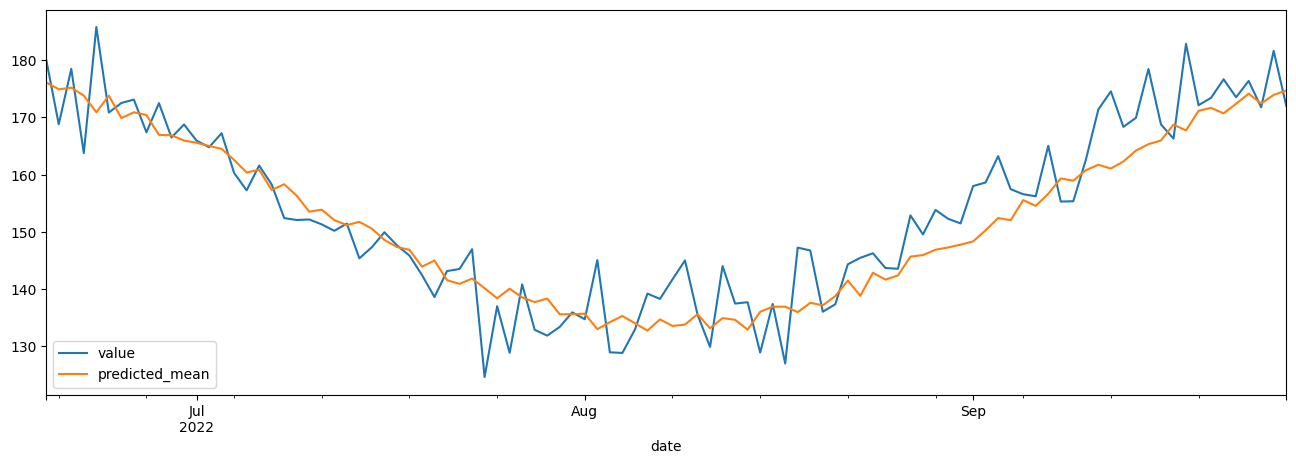

In [21]:
test_df['value'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

Сгенерируем предсказание временного ряда

In [27]:
forecast_steps = 100
forecast_obj = arima_result.get_forecast(steps=forecast_steps)
forecast_values = forecast_obj.predicted_mean
confidence_intervals = forecast_obj.conf_int()
forecast_df = pd.DataFrame({
    'forecast': forecast_values,
    'lower_ci': confidence_intervals.iloc[:, 0],
    'upper_ci': confidence_intervals.iloc[:, 1]
})

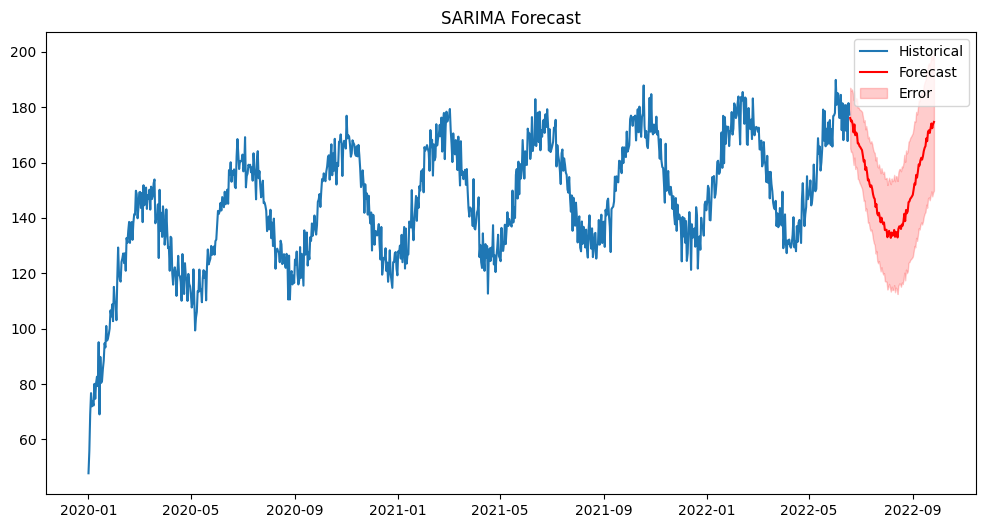

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df['value'], label='Historical')
forecast_index = pd.date_range(
    start=train_df.index[-1], 
    periods=forecast_steps + 1, 
    freq='D'
)[1:]
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')
plt.fill_between(
    forecast_index,
    confidence_intervals.iloc[:, 0],
    confidence_intervals.iloc[:, 1],
    color='red', alpha=0.2, label='Error'
)
plt.legend()
plt.title('SARIMA Forecast')
plt.show()